#  Homework 4

In [281]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import folium
import re
import sys
import networkx as nx

from networkx.algorithms.approximation import min_edge_dominating_set, min_maximal_matching
from networkx.algorithms.approximation import min_maximal_matching
from networkx.algorithms.approximation import min_weighted_dominating_set
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression, LogisticRegression
import sklearn.linear_model.logistic 
from sklearn.model_selection import cross_val_predict, cross_val_score


from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

## Exercise 1

## Question 1: Propensity score matching

In this exercise, you will apply propensity score matching, which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "Evaluating the Econometric Evaluations of Training Programs" (1986). The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program. Your task is to determine the effectiveness of the "treatment" represented by the job training program.

### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the "Design of Observational Studies". Even just reading the first chapter (18 pages) will help you a lot.

#### 1. A naive analysis

>Compare the distribution of the outcome variable (re78) between the two groups, using plots and numbers. To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

>What might a naive "researcher" conclude from this superficial analysis?

To avoid multiple repetitions, we create two functions that will be reused throughout the whole exercise. Validation Hypothesis receives the p-value of a t-test and compare it to our threshold. It delivers a message depending on the validation or not of the null hypothesis. The other function, Compare distributions, will receive two different populations and a feature to compare. It will plot both distributions and perform a student t-test to test the null hypothesis: the mean of both distribution is equal. 

In [282]:
def validation_hypothesis(prob, feature):
    
    # Threshold to validate the null hypothesis
    threshold_prob = 0.005
    
    if (prob>threshold_prob):
        print("The null-hypothesis is validated, the mean of both cases of",feature, "are identical. p-value =",prob)
        return False
    else:
        print("The null-hypothesis is rejected, the mean of both cases of",feature, "are not identical. p-value =",prob)
        return True

In [283]:
def compare_distributions(treat0, treat1, feature, feature_cols):
    fig, ax_ = plt.subplots(figsize=(20,5))

    # We create an histogram for each cases
    treat0.hist(feature, ax = ax_, alpha = 0.5)
    treat1.hist(feature, ax = ax_, alpha = 0.5)

    ax_.legend(('Not participating in the program', 'Participating in the program'))
    plt.show()
    
    # We calculate the t-test with the null-hypothesis that the mean of both distributions is the same.
    t, prob = ttest_ind(treat0[feature], treat1[feature])
    
    # For question 3, we only keep the desired columns
    if (validation_hypothesis(prob, feature)):
        feature_cols.append(feature)
        
    return feature_cols

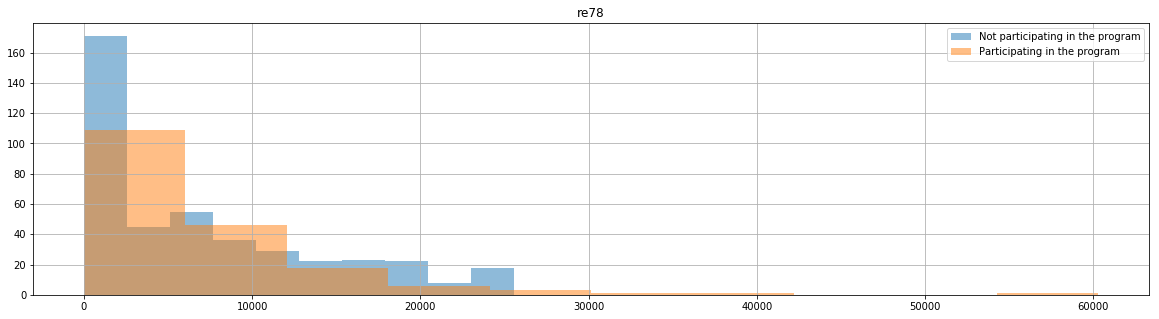

The null-hypothesis is validated, the mean of both cases of re78 are identical. p-value = 0.334249668591


In [284]:
CSV_PATH = 'lalonde.csv'

londe_df = pd.read_csv(CSV_PATH) 
feature_list = ["age","educ","black","hispan","married","nodegree","re74","re75","re78"] 

# Create a different dataset for the treated persons and the others
treat1 = londe_df[londe_df['treat']==1]
treat0 = londe_df[londe_df['treat']==0]

# Create a feature vector that stores the meaningful columns
feature_cols = []

feature = 're78'
feature_cols = compare_distributions(treat0,treat1,feature, feature_cols)

By looking at the distributions for both cases, we can obseve that they look rather similar. The case where the people were not participating in the program seems more dense with a revenue between 0 and 25'000 in 1978, whereas in the other case some people received more, with some outliers around 60'000.
If we look at the t-test, we observe a test statistic of 0.97 and a p-value of 0.33. Our hypothesis that both distribution have equal mean is validated as the p-value stays above our common significance level of 1% (As we have a one-tailed distribution, we measure half of 1%, which is 0.005).

The conclusion from the t-test would lead a naive researcher to think that the program has no effect on the population revenue, and therefore would discard this theory. However, other features might explain the ressemblance in their revenue, without discarding a positive impact of the program.

#### 2. A closer look at the data

>You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above. You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

>For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers. As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

>What do you observe? Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

We can now re-use the code we have written in the previous part in order to estimate which features are relevant for our analysis.

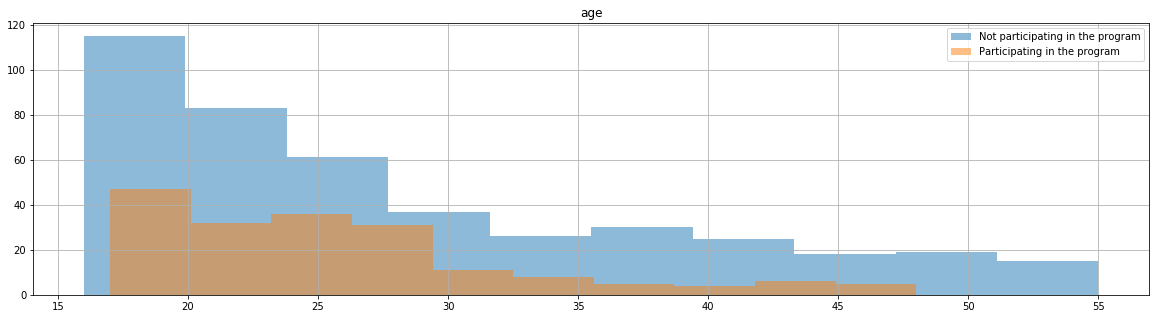

The null-hypothesis is validated, the mean of both cases of age are identical. p-value = 0.0107363325824


In [285]:
feature = 'age'
feature_cols = compare_distributions(treat0,treat1,feature,feature_cols)

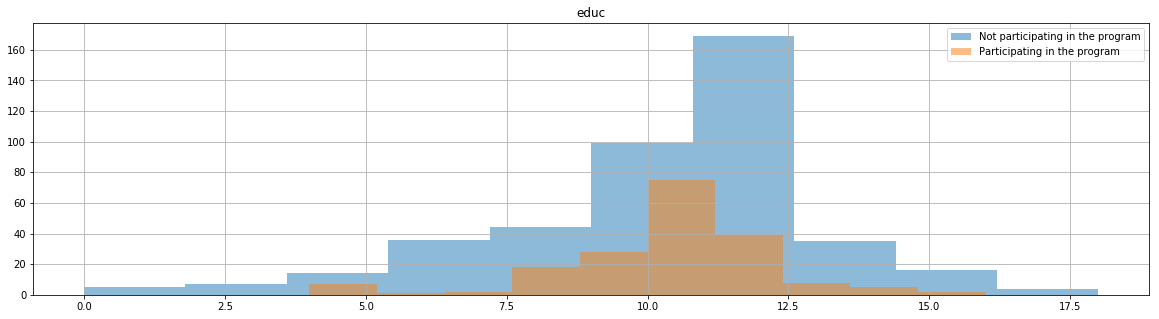

The null-hypothesis is validated, the mean of both cases of educ are identical. p-value = 0.633000972047


In [286]:
feature = 'educ'
feature_cols = compare_distributions(treat0,treat1,feature,feature_cols)

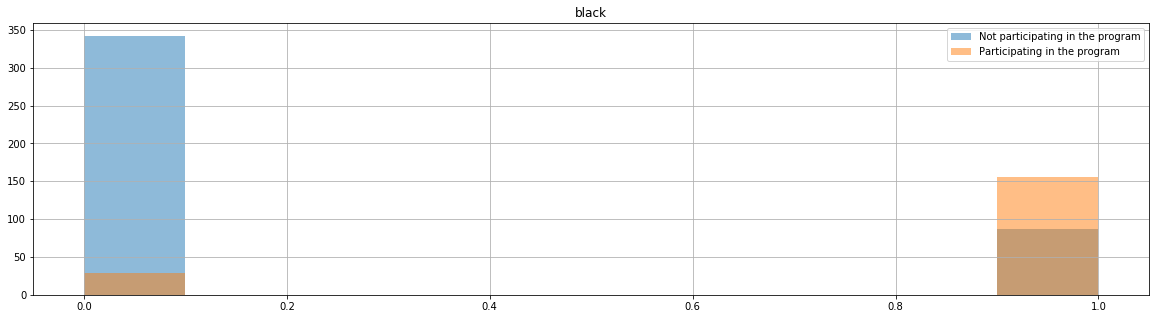

The null-hypothesis is rejected, the mean of both cases of black are not identical. p-value = 1.56007825122e-61


In [287]:
feature = 'black'
feature_cols = compare_distributions(treat0,treat1,feature,feature_cols)

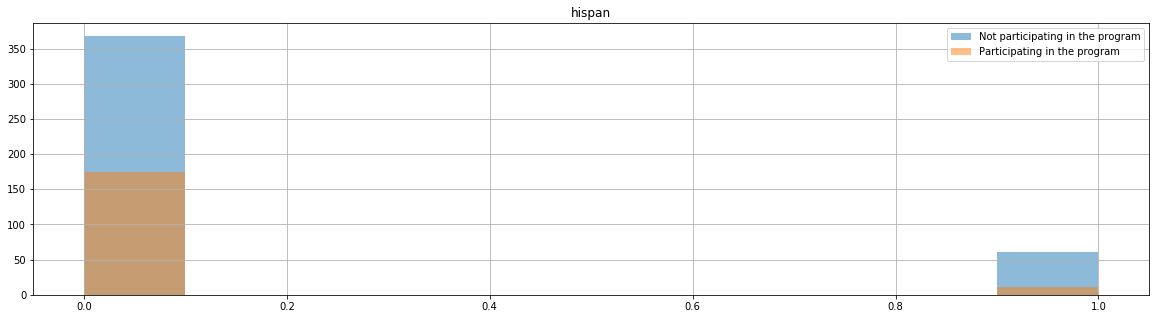

The null-hypothesis is rejected, the mean of both cases of hispan are not identical. p-value = 0.00341386049709


In [288]:
feature = 'hispan'
feature_cols = compare_distributions(treat0,treat1,feature,feature_cols)

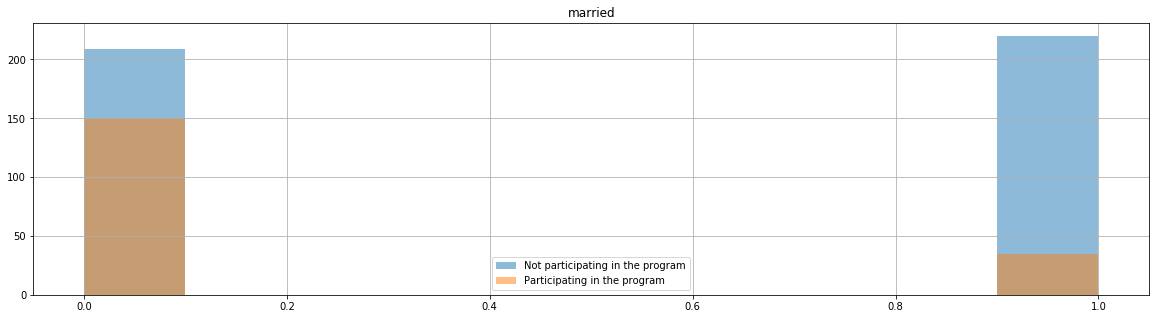

The null-hypothesis is rejected, the mean of both cases of married are not identical. p-value = 2.35512414069e-14


In [289]:
feature = 'married'
feature_cols = compare_distributions(treat0,treat1,feature,feature_cols)

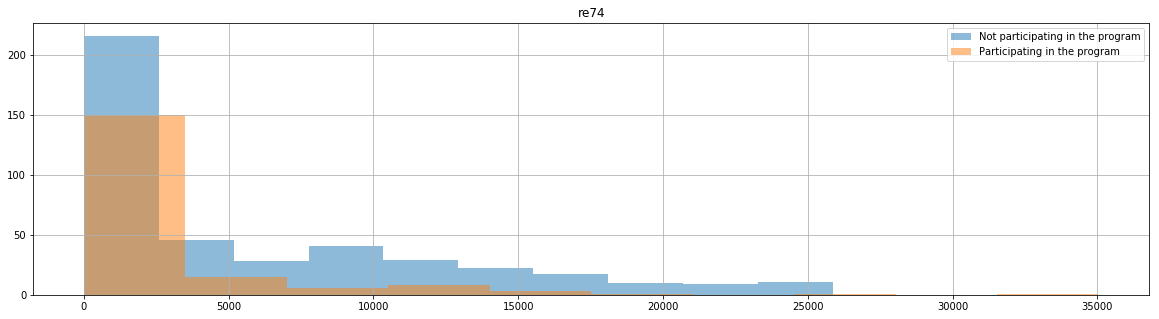

The null-hypothesis is rejected, the mean of both cases of re74 are not identical. p-value = 3.46458525776e-10


In [290]:
feature = 're74'
feature_cols = compare_distributions(treat0,treat1,feature,feature_cols)

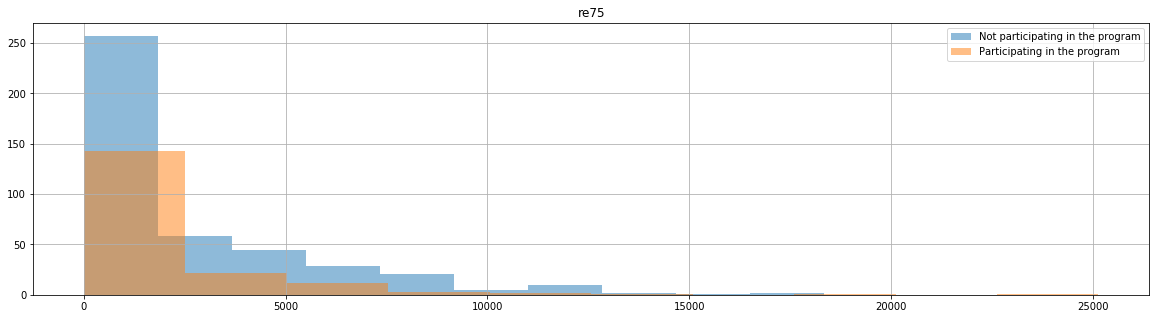

The null-hypothesis is rejected, the mean of both cases of re75 are not identical. p-value = 0.00122344439485


In [291]:
feature = 're75'
feature_cols = compare_distributions(treat0,treat1,feature,feature_cols)

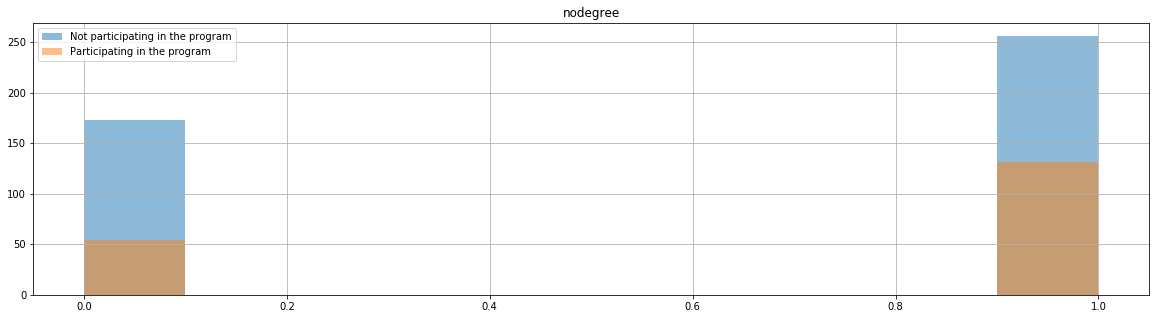

The null-hypothesis is validated, the mean of both cases of nodegree are identical. p-value = 0.00866309085702


In [292]:
feature = 'nodegree'
feature_cols = compare_distributions(treat0,treat1,feature,feature_cols)

In [293]:
print('Relevant Features: ', feature_cols)

Relevant Features:  ['black', 'hispan', 'married', 're74', 're75']


By analysing the other features of the dataset, we observe that some of them might explain a difference of measurements in revenue between the treated and non-treated groups. We displayed above the features that would help us do a proper analysis: "black", "hispan", "married", "re74", "re75". 

The naive researcher would have stopped his analysis in the previous question, when a further one is actually needed with this observation.

#### 3. A propensity score model

>Use logistic regression to estimate propensity scores for all points in the dataset. You may use sklearn to fit the logistic regression model and apply it to each data point to obtain propensity scores:

>Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.). To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or this article.

>Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. It's sole purpose is to balance the dataset across treatment groups. (See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores. If you want even more information, read this article.)

For this part, we will apply Logistic Regression to our dataset. As our datas present different forms (revenue or binary values), it is necessary to standardize them before anything. We only keep the relevent features found on question 2 for this part.

As we have different features, we need to standardize all of them to ease up the regression process.

In [294]:
def standardize(df):
    """Standardize the original dataframe."""
    standard_df = pd.DataFrame()
    for column in df:
        mean_column = df[column].mean()
        std_column = df[column].mean()
        standard_df[column] = (df[column]-mean_column)/std_column
    return standard_df

In [295]:
def movingaverage(interval, window_size):
    """Perform a moving average of the data - here for vizualisation purposes"""
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [296]:
def accuracy_measures(pred):
    """Measures the accuracy, the precision and the recall of our prediction"""
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(0,pred[:,1].shape[0]):
        if i < treat1.shape[0]:
            if pred[i,1] > 0.5:
                TP += 1
            else:
                FN += 1

        else:
            if pred[i,1] > 0.5:
                FP += 1
            else:
                TN += 1

    Acc = float(TP + TN)/float(TP + TN + FP + FN)
    Pre = TP/float(TP+FP)
    Rec = TP/float(TP+FN)

    print('Accuracy =', 100*Acc, '%  Precision =', 100*Pre , '% Recall =', 100*Rec,'%')

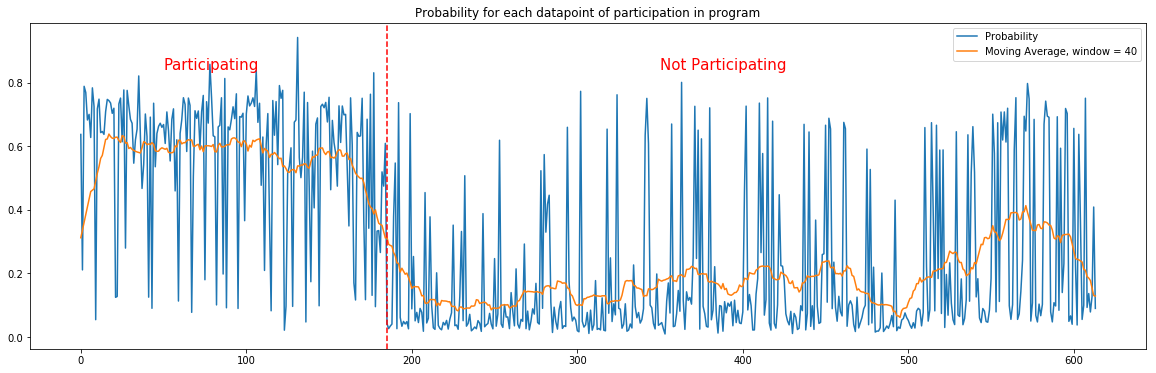

Accuracy = 81.59609120521174 %  Precision = 66.98113207547169 % Recall = 76.75675675675676 %


In [297]:
X = londe_df[feature_list]
y = londe_df.treat

# Standardize the features
X = standardize(X)

# Logistic Regression on the data
logistic = LogisticRegression()
logistic.fit(X,y)

# Estimate Propensity score
pred = logistic.predict_proba(X)

# Plot of Propensity score
fig, ax_ = plt.subplots(figsize=(20,6))
plt.plot(pred[:,1])
plt.title('Probability for each datapoint of participation in program')
plt.plot(movingaverage(pred[:,1], 30))
plt.axvline(treat1.shape[0],color='r', linestyle='--')

ax_.text(50, 0.84, r'Participating',color='r', fontsize=15)
ax_.text(350, 0.84, r'Not Participating',color='r', fontsize=15)

plt.legend(['Probability', 'Moving Average, window = 40'])
plt.show()

accuracy_measures(pred)

We plotted above the propensity score for each datapoint. At the left of the red dotted line, we observe the population participating in the program, whereas on the right there are the one not participating in it. By looking at the general tendancy of each of them through a moving average, it seems to be able to predict a majority of the cases.

Our accuracy and recall stay quite high, but our precision is not.

#### 4. Balancing the dataset via matching

>Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group. (Hint: you may explore the networkx package in Python for predefined matching functions.)

>Your matching should maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

>After matching, you have as many treated as you have control subjects. Compare the outcomes (re78) between the two groups (treated and control).

>Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects. What do you observe? Are you closer to being able to draw valid conclusions now than you were before?

For this part of the exercise, we won't use the networkx package but rather write our own matching function. It will simply go through all treated persons and find the closest non-treated person for the feature we're looking for. When found, it adds the non-treated person to the matching dataset. Then it is removed from its previous positions to avoid double matching with the same person.

In [298]:
def matching(treat0, treat1, comparison_feature):
    match_df = treat1
    
    # For every row of the treated population
    for index, row in treat1.iterrows():
        match_idx = 0
        lowest_diff = 10000000 # Random, just sufficiently high to be above all features maxima

        # We look at every non-treated population
        for index_, row_ in treat0.iterrows():
            # To keep only the closest one in propensity scores
            diff = abs(row[comparison_feature]-row_[comparison_feature])
            # We store the one with the best results
            if (diff < lowest_diff):
                lowest_diff = diff
                match_idx = index_
                match_row = row_

        # And add it to our matching dataframe
        match_df.loc[-1] = match_row
        match_df.index = match_df.index + 1  # Shifting index
        match_df = match_df.sort_index()

        # We drop the added row to only get one match per treated person
        treat0.drop(match_idx)
    
    return match_df

/Users/Julie/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Julie/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/Julie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pa

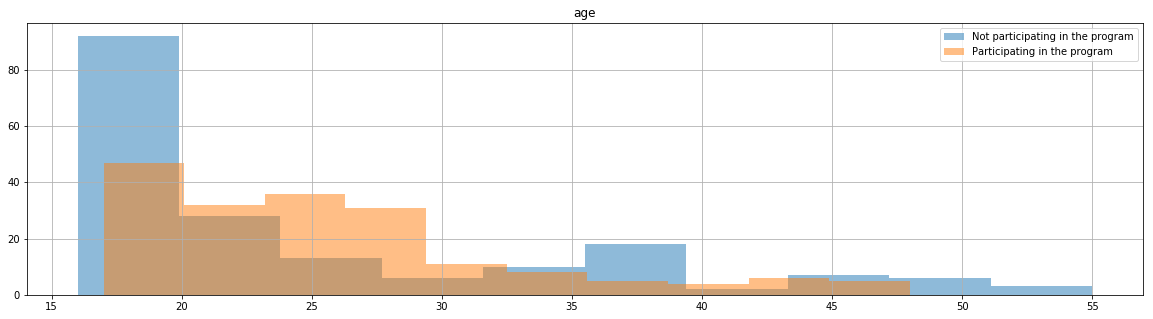

The null-hypothesis is validated, the mean of both cases of age are identical. p-value = 0.289488545681


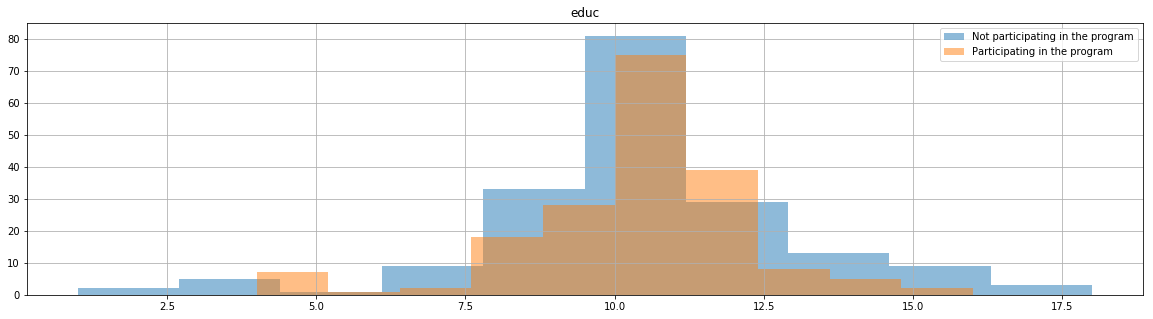

The null-hypothesis is validated, the mean of both cases of educ are identical. p-value = 0.391293824175


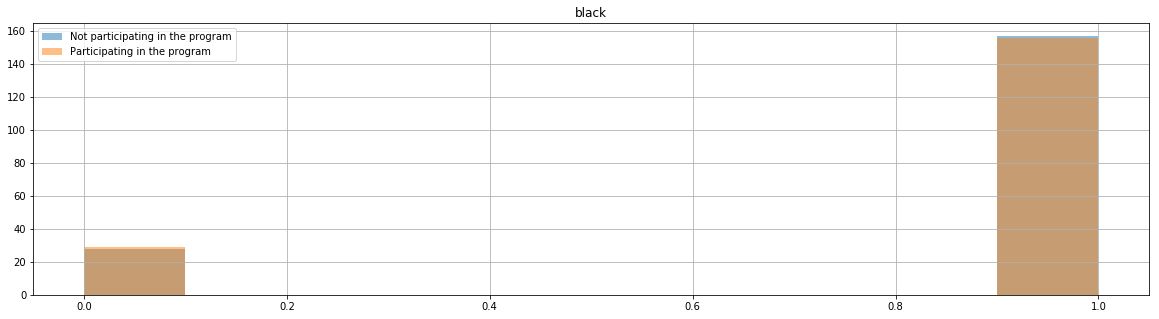

The null-hypothesis is validated, the mean of both cases of black are identical. p-value = 0.885876140648


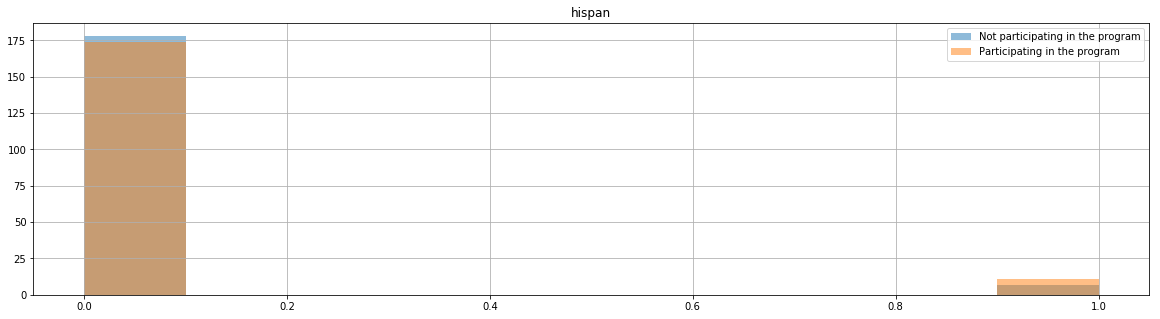

The null-hypothesis is validated, the mean of both cases of hispan are identical. p-value = 0.335069548631


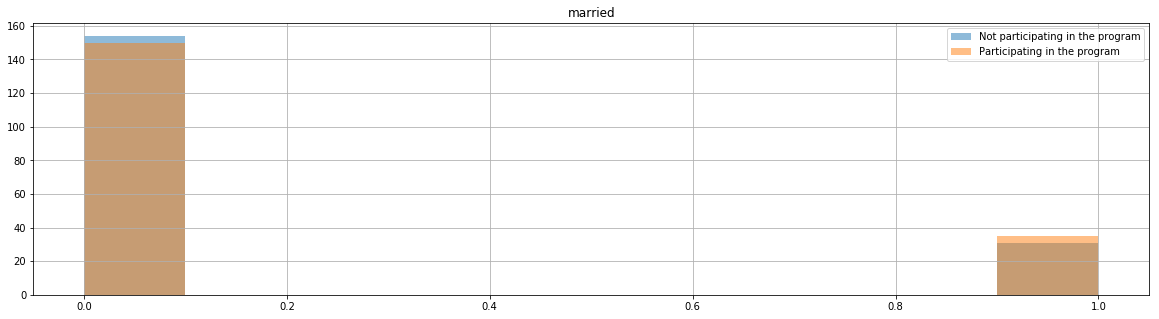

The null-hypothesis is validated, the mean of both cases of married are identical. p-value = 0.588190255375


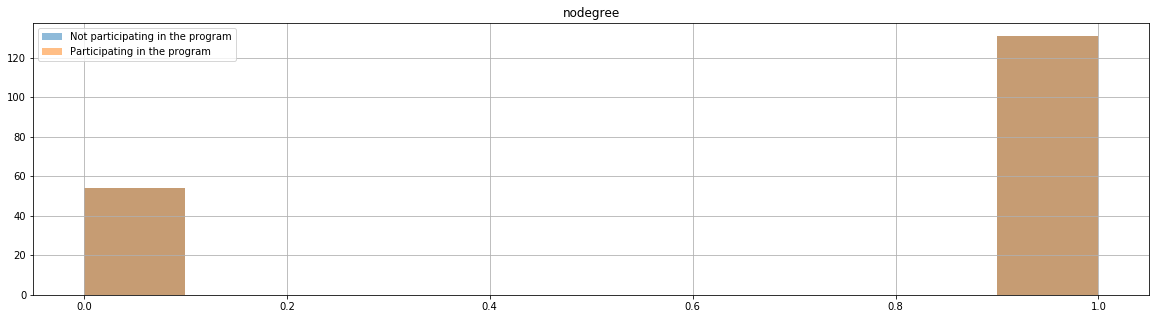

The null-hypothesis is validated, the mean of both cases of nodegree are identical. p-value = 1.0


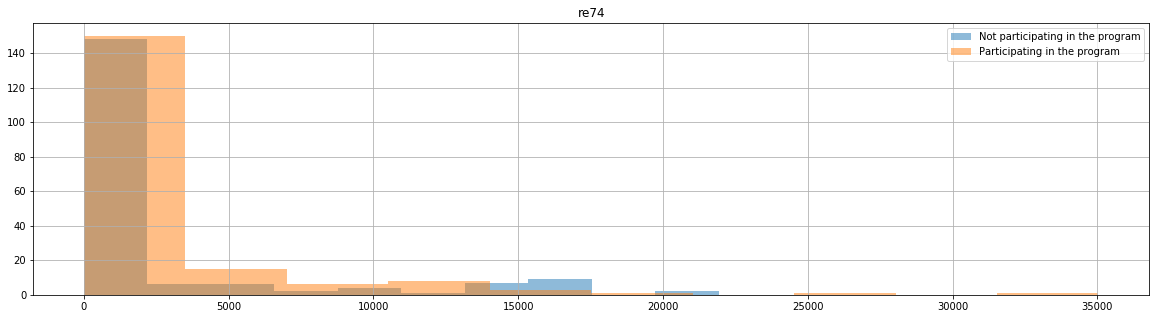

The null-hypothesis is validated, the mean of both cases of re74 are identical. p-value = 0.388613686995


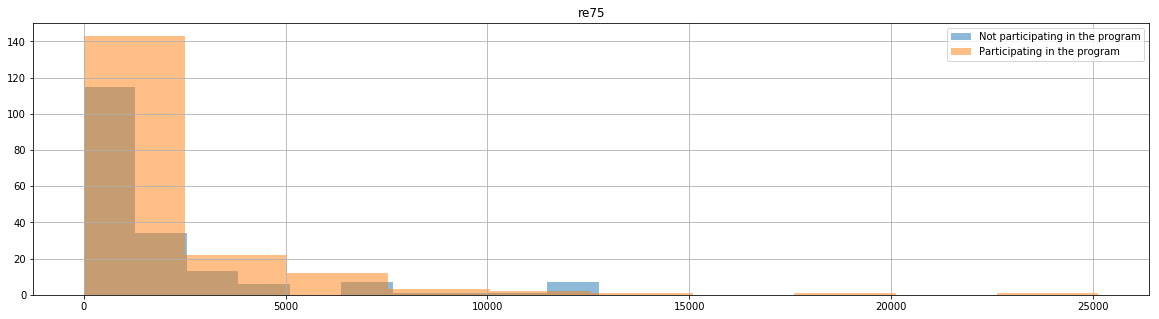

The null-hypothesis is validated, the mean of both cases of re75 are identical. p-value = 0.414727187594


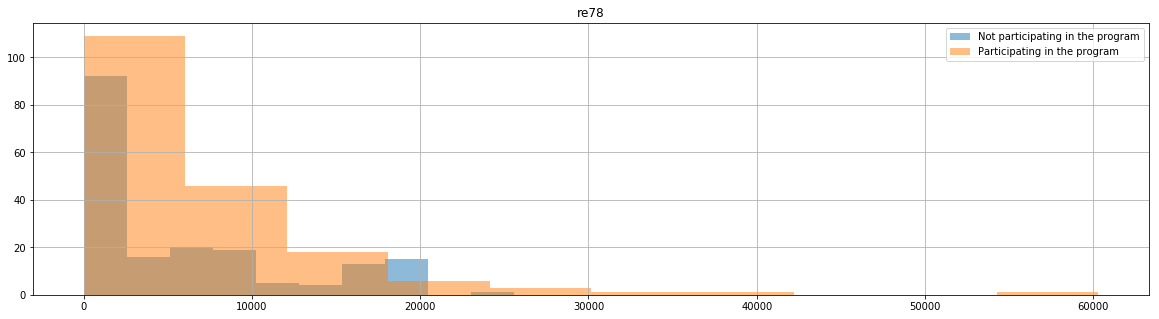

The null-hypothesis is validated, the mean of both cases of re78 are identical. p-value = 0.430229923381


In [299]:
# Separation between non-treated and treated populations
treat0.loc[:,'propensity'] = pred[treat1.shape[0]:,1]
treat1.loc[:,'propensity'] = pred[:treat1.shape[0],1]

match_df = matching(treat0,treat1, 'propensity')

match0 = match_df[match_df['treat'] == 0]
match1 = match_df[match_df['treat'] == 1]

for feature in feature_list:
    # Just change the treat0 and treat1 to the matching dataframes
    _ = compare_distributions(match0_2,match1_2,feature, feature_cols)

After matching, we observe now that all features present a similar mean between the treated and non-treated population. 

The t-test performed on the revenues in 1978 would make us think that both distributions are similar.

#### 5. Balancing the groups further

>Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching? Would you say your dataset is sufficiently balanced? If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

>Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature. Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

The matching from question 4 is still not satisfactory. We have decided to match subjects that were similar across all features by comparing only the propensity score. 

It might be more interesting to compare subjects with the same revenue in 1978 in order to observe all other features to draw a valid conclusion.

/Users/Julie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


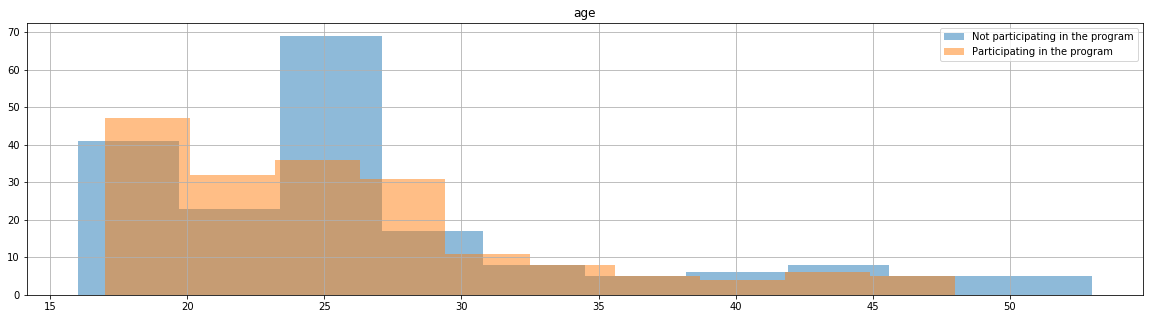

The null-hypothesis is validated, the mean of both cases of age are identical. p-value = 0.399189055055


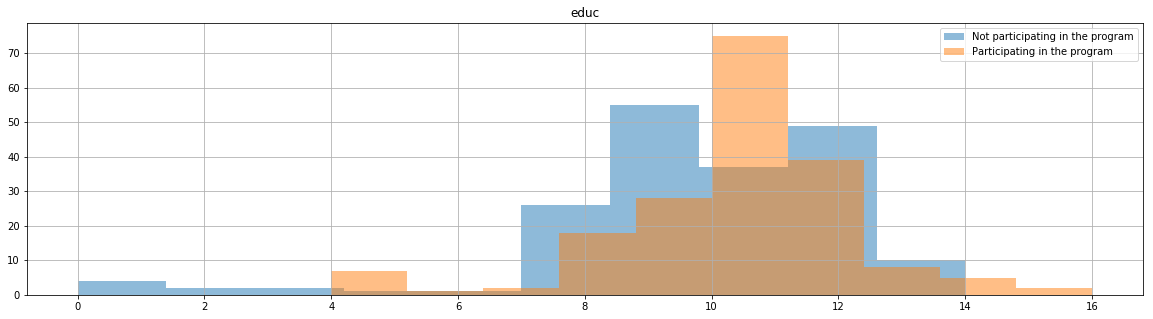

The null-hypothesis is validated, the mean of both cases of educ are identical. p-value = 0.0123819400377


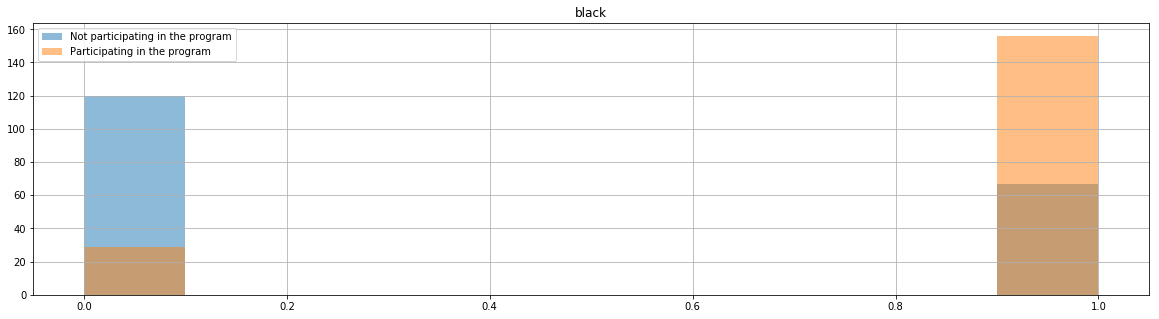

The null-hypothesis is rejected, the mean of both cases of black are not identical. p-value = 2.26078814019e-24


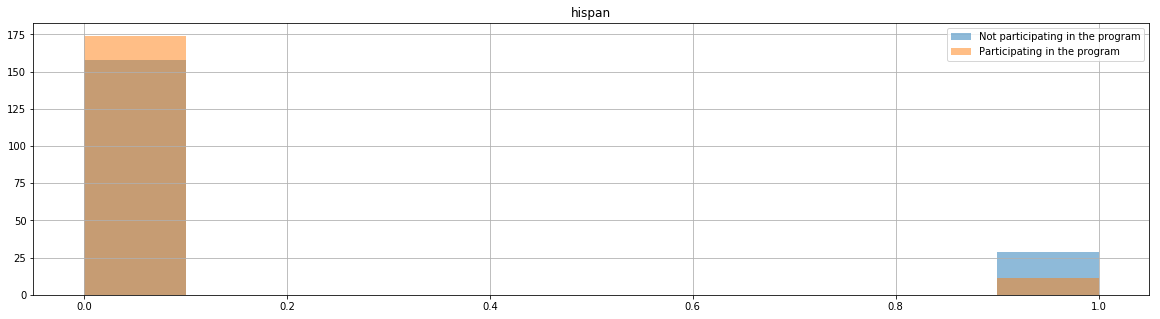

The null-hypothesis is rejected, the mean of both cases of hispan are not identical. p-value = 0.00283988907658


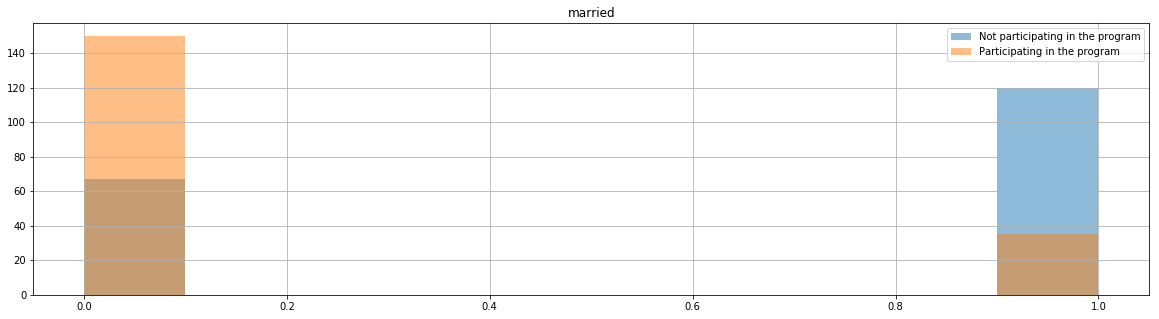

The null-hypothesis is rejected, the mean of both cases of married are not identical. p-value = 8.89956410865e-21


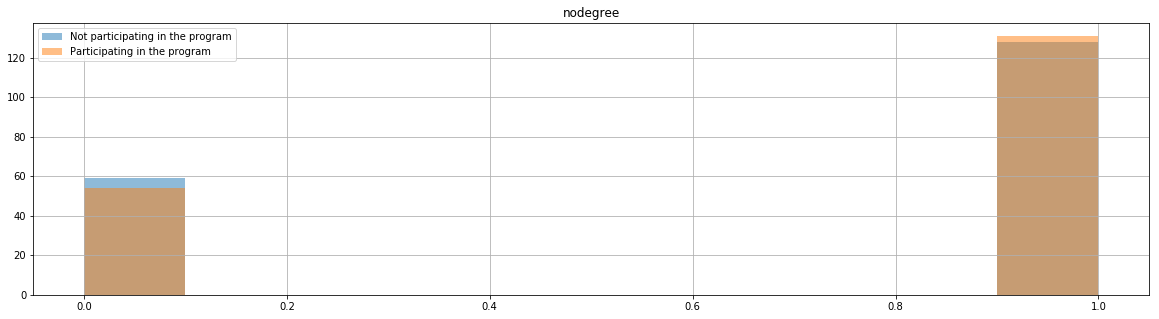

The null-hypothesis is validated, the mean of both cases of nodegree are identical. p-value = 0.621564480461


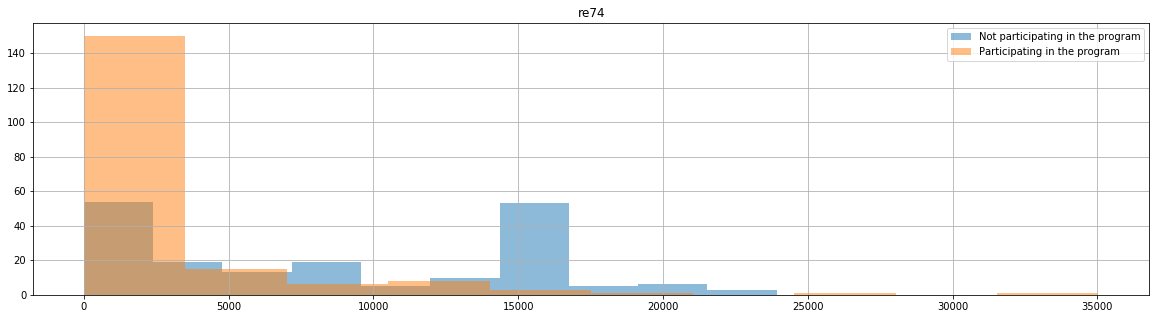

The null-hypothesis is rejected, the mean of both cases of re74 are not identical. p-value = 2.71514429639e-22


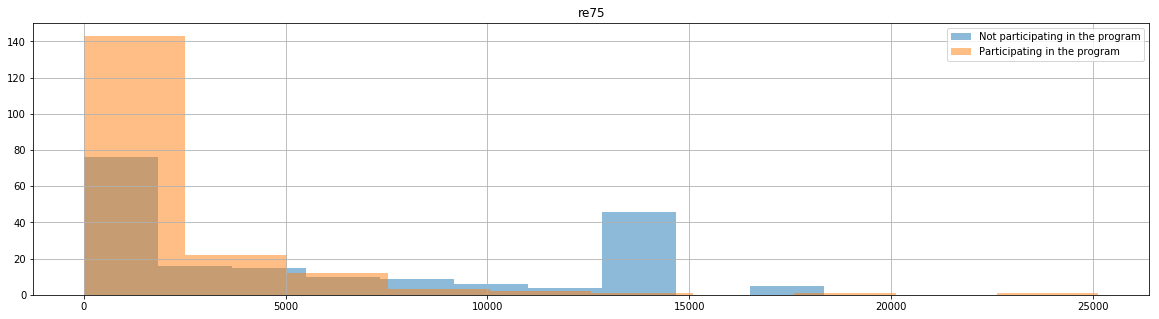

The null-hypothesis is rejected, the mean of both cases of re75 are not identical. p-value = 9.41798535752e-18


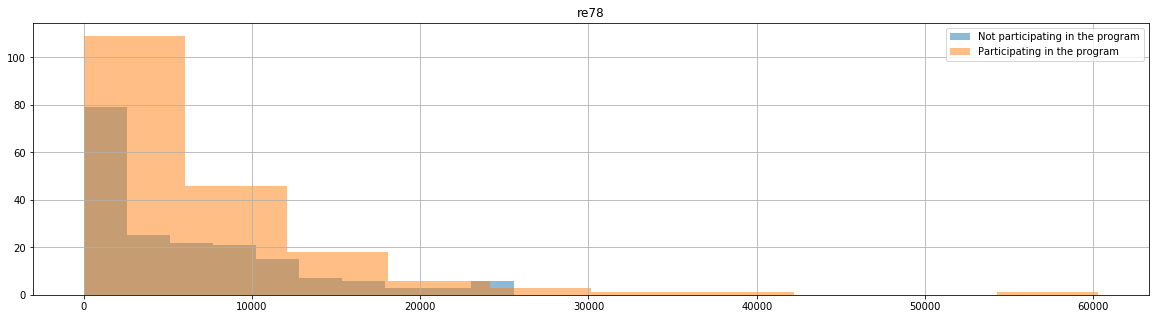

The null-hypothesis is validated, the mean of both cases of re78 are identical. p-value = 0.619860818695


In [300]:
match_df = matching(treat0, treat1, 're78')

for feature in feature_list:
    # Just change the treat0 and treat1 to the matching dataframes
    _ = compare_distributions(match_df[match_df['treat'] == 0],match_df[match_df['treat'] == 1],feature, feature_cols)

We observe that 5 features have different distributions between both groups: black, hispan, married, re74 & re75.
From there, we observe that the treated population was regrouping more black persons, less hispanics, mainly single and with lower income in both 74 and 75. 

We now have a clear difference between both populations.

#### 6. A less naive analysis

>Compare the outcomes (re78) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5. What do you conclude about the effectiveness of the job training program?

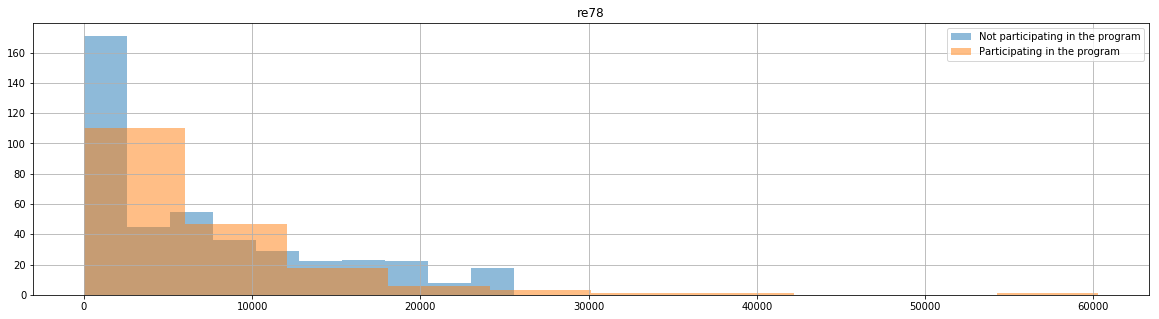

The null-hypothesis is validated, the mean of both cases of re78 are identical. p-value = 0.320856383431


In [301]:
# Use only the final treated dataframes
feature = 're78'
_ = compare_distributions(treat0,treat1,feature, feature_cols)

With the differences between both populations shown on question 4, we observe that the treated population was presenting lower incomes in 1974 and 1975, but they were able to reach a similar one in 1978.

This changes takes place after the program has been offered to them, we can conclude with this analysis that the job training program was effective for those persons.

## Exercise 2

### Part 1

Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn (link).

In [2]:
newsgroups = fetch_20newsgroups(subset='all')

In [3]:
list(newsgroups.keys())

['data', 'filenames', 'target_names', 'target', 'DESCR', 'description']

#### TFIDF Matrix

We calculate the TF-IDF Matrix. While calculating this matrix, several paramters can be specified:

`strip_accent`:  Remove accent during the preprocessing step

`lowercase`: Convert all characters to lowercase before tokenizing

`stop_words`: Remove all the english stop words

`ngram_range`: is set to (1,1) to specify that we consider only unigram



In [4]:
vectorizer = TfidfVectorizer(strip_accents="unicode", lowercase = True, stop_words = 'english', ngram_range=(1, 1) )
X = vectorizer.fit_transform(newsgroups.data)
X.shape

(18846, 173440)

In [5]:
y = newsgroups.target

#### Split Data

We split the data in three sets, a training set, a test set and a validation set. To to this we can use twice the method train_test_split. This method split a tuple (X,y) into a test and train set following a ratio.

If we split the set firt with a ratio of 0.1, we have a train set of 90% and a test set of 10%. We can then split the train set with the same ratio, which gives us a train set of 80% and another "test" set of 10% which will be our validation set

In [6]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=1)

X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=0.1, random_state=1)

### Part 2

Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the feature_importances_ attribute of your random forest and discuss the obtained results.



### Random forest classifier

In [7]:
classifier = RandomForestClassifier()

#### Parameter estimation

In [10]:
li = range(200)
sub = li[1::10]

param_grid = { 
    'n_estimators': [1,10, 20, 50, 70, 100, 125, 150, 175, 200],#sub,#np.ndarray(10, 200),#np.arange(10, 200, 10),#[10: 200],
    'max_depth': [3, None]#sub#sp_randint(10, 200)#np.arange(10, 200, 10)#[10: 200]
}

CV_rfc = GridSearchCV(estimator=classifier, param_grid=param_grid)
CV_rfc.fit(X, y)

{'max_depth': None, 'n_estimators': 175}


We can extract the scores depending on the parameters

In [11]:
df = pd.DataFrame.from_dict(CV_rfc.cv_results_)
param_df = pd.DataFrame(CV_rfc.cv_results_.get('params'))
param_df = param_df[['n_estimators', 'max_depth']]
result_df = df[['mean_test_score', 'rank_test_score']]
result_df = pd.concat([result_df, param_df], axis= 1, join='inner')

In [12]:
result_df.sort_values('rank_test_score')

,mean_test_score,rank_test_score,n_estimators,max_depth
18,0.867027,1,175,NaN
19,0.866232,2,200,NaN
17,0.862836,3,150,NaN
16,0.862783,4,125,NaN
15,0.858060,5,100,NaN
14,0.851480,6,70,NaN
13,0.842725,7,50,NaN
12,0.796084,8,20,NaN
11,0.730712,9,10,NaN
9,0.638279,10,200,3.0


We can see that we achive the best score with a number of estimators equal to 175 and no max depth.

With these parameters we achieve a score of 0.867

In [17]:
clf = CV_rfc.best_estimator_

#### Confusion Matrix

In [19]:
y_pred = clf.predict(X_te)

In [20]:
print(confusion_matrix(y_te, y_pred))

[[ 78   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0 101   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0  96   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0 110   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0 101   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0 101   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0  93   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0 109   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0 103   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0 101   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0 110   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 104   0   0   0   0

#### Feature Importance

In [65]:
importances = clf.feature_importances_
feature_name = dict([[v,k] for k,v in vectorizer.vocabulary_.items()])


std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(20):
    print("%d. feature %s (%f)" % (f + 1, feature_name[indices[f]], importances[indices[f]]))



Feature ranking:
1. feature sale (0.005504)
2. feature windows (0.005307)
3. feature dod (0.004996)
4. feature bike (0.003871)
5. feature car (0.003768)
6. feature clipper (0.003665)
7. feature hockey (0.003066)
8. feature mac (0.002877)
9. feature space (0.002840)
10. feature encryption (0.002808)
11. feature baseball (0.002762)
12. feature israel (0.002617)
13. feature god (0.002466)
14. feature cars (0.002452)
15. feature writes (0.002424)
16. feature rutgers (0.002414)
17. feature graphics (0.002400)
18. feature lines (0.002315)
19. feature organization (0.002284)
20. feature game (0.002276)
